### Generate Plot of Q

Code which takes a function and calculates the mapping of the set Q
and generates Figures such as Figure 4 and 5 in the paper

Also shows how to extract PID Component Values from this computation

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from copy import copy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def entropy(Fp,Hix):
    Hnot=tuple({0,1,2}-Hix)
    Fsum=np.sum(Fp,axis=Hnot)
    return -np.nansum(Fsum*np.log(Fsum))
  
def dgps(Fp):
    Hi=np.array([entropy(Fp,{i}) for i in range(3)])
    Hij=np.array([entropy(Fp,{0,1,2}-{i}) for i in range(3)])
    HijHjk=np.sum(Hij)-Hij
    Hijk=entropy(Fp,{0,1,2})
    omega=np.sum(Hi)-Hijk
    delta=(-Hi+HijHjk-Hijk)/omega
    Hall={'Hi':Hi,'Hij':Hij,'Hijk':Hijk}
    return delta,omega,Hall

def get_abgd(X,res=21):
    r2=int(res/2)
    #label entries of matrix
    a,b,c,d,e,f,g,h,i=X.ravel()
    #get alpha (and beta) which satisfy:
    # 0 <= a+alph <= 1
    # 0 <= b+beta <= 1
    alpha=np.hstack([np.linspace(-a,0,r2),[0],np.linspace(0,1-a,r2)])
    beta=np.hstack([np.linspace(-b,0,r2),[0],np.linspace(0,1-b,r2)])
    ab=np.vstack([[i,j] for i,j in itertools.product(alpha,beta)])
    ab=np.unique(ab,axis=0)
    #enforce:
    # 0 <= c-alph-beta <= 1
    ab=ab[(ab.sum(1)<=c)&(ab.sum(1)>=(c-1))]

    #do same as above, but for next row:
    # 0 <= d+gamma <= 1
    # 0 <= e+delta <= 1
    # 0 <= f-gamma-delta <= 1
    #gamma=np.linspace(-d,1-d,res)
    #delta=np.linspace(-e,1-e,res)
    gamma=np.hstack([np.linspace(-d,0,r2),[0],np.linspace(0,1-d,r2)])
    delta=np.hstack([np.linspace(-e,0,r2),[0],np.linspace(0,1-e,r2)])
    de=np.vstack([[i,j] for i,j in itertools.product(gamma,delta)])
    de=de[(de.sum(1)<=f)&(de.sum(1)>=(f-1))]
    de=np.unique(de,axis=0)
    #stack into possible combos of alpha,beta,gamma,delta which satisfy above inequalities
    abgd=np.vstack([np.hstack([i,j]) for i,j in itertools.product(ab,de)])
    ag=abgd[:,[0,2]]
    bd=abgd[:,[1,3]]

    #enforce column inequalities:
    # 0 <= g-alpha-gamma <= 1
    # 0 <= h-beta-delta <= 1
    # 0 <= i-alpha-beta-gamma-delta <=1
    abgd=abgd[(ag.sum(1)<=g)&(ag.sum(1)>=(g-1))&(bd.sum(1)<=h)&(bd.sum(1)>=(h-1))]
    abgd=abgd[(abgd.sum(1)>=-i)&(abgd.sum(1)<=(1-i))]
    
    return abgd

def permute_X(X,abgd):
    if len(abgd.shape)==1:
        a,b,g,d=abgd
        dX=np.array([[a,b,-a-b],[g,d,-g-d],[-a-g,-b-d,a+b+g+d]])
        return X+dX
    if len(abgd.shape)==2:
        return [permute_X(X,abgd_k) for abgd_k in abgd]
    #will only get here if abgd is neither one nor two dimensional
    raise Exception('second argument of permute_X has invalid dimension')
    
def abgd_boundary(X,res=51):
    a,b,c,d,e,f,g,h,i=X.ravel()

    abgd=get_abgd(X,res=res).T
    alpha,beta,gamma,delta=[np.unique(ak) for ak in abgd]

    ck=np.vstack([[a,c,g,i],[b,c,h,i],[d,f,g,i],[e,f,h,i]])
    xk=np.vstack([[0,1],[0,2],[2,0],[2,1]])

    abgd0=np.array([alpha,beta,gamma,delta])
    As=[]
    for n in range(4):
        jkl=np.array(list(set(range(4))-{n}))
        abg=np.vstack([abgk for abgk in itertools.product(*abgd0[jkl])]).T

        c0,c1,c2,c3=ck[n]
        x0,x1=xk[n]

        amin=np.max(np.vstack([-c0*np.ones(abg.shape[1]),c1-abg[x0]-1,c2-abg[x1]-1,-c3-np.sum(abg,axis=0)]),axis=0)
        amax=np.min(np.vstack([1.0-c0*np.ones(abg.shape[1]),c1-abg[x0],c2-abg[x1],1-c3-np.sum(abg,axis=0)]),axis=0)

        aix=amax>amin

        Na=np.sum(aix)
        A=np.zeros((4,2*Na))
        A[jkl,:Na]=abg[:,aix]
        A[n,:Na]=amin[aix]
        A[jkl,Na:]=abg[:,aix]
        A[n,Na:]=amax[aix]

        As.append(A)

    As=np.hstack(As)


    tA=np.vstack([a+As[0],b+As[1],d+As[2],e+As[3],c-As[0]-As[1],f-As[2]-As[3],g-As[0]-As[2],h-As[1]-As[3],i+As.sum(0)])
    goodx=(np.sum((tA==0)|(tA==1),0)>0)&np.all(tA<=1,0)&np.all(tA>=0,0)
    
    if np.sum(goodx)==0:
        return np.zeros((4,1))
    As=As[:,goodx]
    As=np.unique(As,axis=1)
    return As
    

In [2]:
import warnings

ix=np.array([[0,1,2]]*3)
x=ix.ravel(order='F')
y=ix.ravel(order='C')


# FUNCTION TO BE CALCULATED
# CHANGE THIS TO CALCULATE Q FOR A DIFFERENT FUNCTION
Z=[1,0,0,0,1,1,1,2,1]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    F=np.zeros((3,3,3))
    F[x,y,Z]=1
    F=F/np.sum(F)

    d0,o0,_=dgps(F)

    Xlist=[]
    for fk in range(F.shape[-1]):
        f=F[:,:,fk]
        p0=abgd_boundary(f,res=101).T
        Xlist.append(permute_X(f,p0))

    D=[]
    O=[]
    H=[]
    for f1k,f2k,f3k in itertools.product(*Xlist):
        Fp=np.dstack([f1k,f2k,f3k])
        d,o,h=dgps(Fp)
        D.append(d*o)
        O.append(o)
        H.append(h)
    D=np.vstack(D)
    O=np.array(O)


    Hxyz=np.array([h['Hijk'].round(8) for h in H])
    Hxy=np.array([h['Hij'][-1].round(8) for h in H])

    MI=np.array([np.sum(h['Hi'][:2])-h['Hij'][2] for h in H])


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


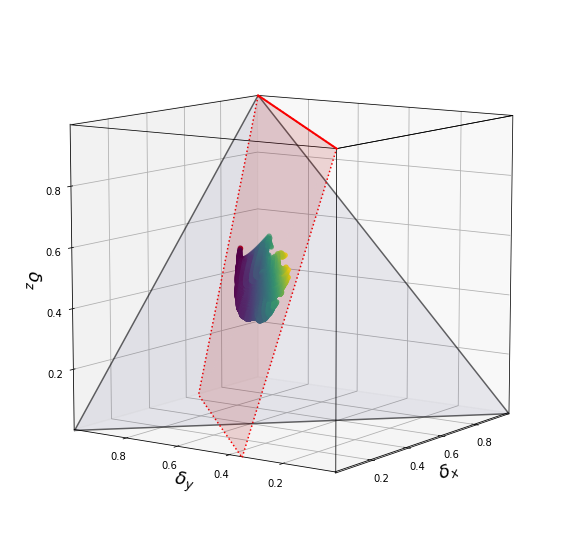

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('$\delta_x$',fontsize=18)
plt.ylabel('$\delta_y$',fontsize=18)
ax.set_zlabel('$\delta_z$',fontsize=18)

cmin=-2*h['Hi'][0]+h['Hij'][0]-h['Hi'][2]+h['Hi'][0]
H12min=-1.0/9*(3*np.log(3.0/9)+4*np.log(2.0/9)+2*np.log(1.0/9))
cmax=-H12min+h['Hij'][0]-h['Hi'][2]+h['Hi'][0]
I23=h['Hij'][0]-h['Hi'][1]-h['Hi'][2]
ax.plot_trisurf([0,1,1],[1,0,1],[0,0,1],color=[0,0,0.3,0.07])
ax.plot([0,1,1,0],[1,0,1,1],[0,0,1,0],color=[0,0,0,0.6])

cn=(d0[0]-d0[1])/(1-d0[2])

ax.view_init(10, 225)
ax.plot_trisurf([0,1,1+cn,0],[0,1,1,-cn],[1,1,0,0],color=[1,0,0,0.15])
ax.plot([0,1,1+cn,0,0],[0,1,1,-cn,0],[1,1,0,0,1],':',color=[1,0,0,1.0])
ax.plot([0,0,1,1,0],[0,1,1,0,0],[1,1,1,1,1],color=[0,0,0,1],lw=0.75)
ax.plot([0,0,1,1,0],[0,0,0,0,0],[0,1,1,0,0],color=[0,0,0,1],lw=0.75)
ax.plot([0,1],[0,1],[1,1],color=[1,0,0],lw=2)
ax.scatter(d0[0],d0[1],d0[2],c=[1,0,0])
plt.xlim([0.03,0.99])
plt.ylim([0.03,0.99])
ax.set_zlim([0.02,0.98])
ax.view_init(10,215)

im = ax.scatter(D[:,0]/O,D[:,1]/O,D[:,2]/O,c=MI)



In [4]:
I_12_3=o0/2*(d0[0]+d0[1]-d0[2]+1)
d=(D/O[:,None]).T
U0=np.min(d[1]*o)
U1=np.min(d[0]*o)
R=np.max(o/2*(1-d.sum(0)))
S=I_12_3-np.min(o/2*(d[0]+d[1]-d[2]+1))

print('Total Information in Each Component')
print('U_x = {:0.3f}'.format(U0))
print('U_y = {:0.3f}'.format(U1))
print('R = {:0.3f}'.format(R))
print('S = {:0.3f}'.format(S))

print('Proportion in Each Component')
print('U_x = {:0.3f}'.format(U0/I_12_3))
print('U_y = {:0.3f}'.format(U1/I_12_3))
print('R = {:0.3f}'.format(R/I_12_3))
print('S = {:0.3f}'.format(S/I_12_3))

Total Information in Each Component
U_x = 0.255
U_y = 0.094
R = 0.059
S = 0.528
Proportion in Each Component
U_x = 0.273
U_y = 0.100
R = 0.063
S = 0.564
